Using TensorFlow backend.


Epoch 1/10
596/595 [==============================] - 197s - loss: 0.0387 - val_loss: 0.0237
Epoch 2/10
596/595 [==============================] - 143s - loss: 0.0312 - val_loss: 0.0221
Epoch 3/10
596/595 [==============================] - 144s - loss: 0.0290 - val_loss: 0.0243
Epoch 4/10
596/595 [==============================] - 243s - loss: 0.0278 - val_loss: 0.0231
Epoch 5/10
596/595 [==============================] - 160s - loss: 0.0265 - val_loss: 0.0200
Epoch 6/10
596/595 [==============================] - 143s - loss: 0.0258 - val_loss: 0.0218
Epoch 7/10
596/595 [==============================] - 146s - loss: 0.0251 - val_loss: 0.0180
Epoch 8/10
596/595 [==============================] - 146s - loss: 0.0245 - val_loss: 0.0189
Epoch 9/10
596/595 [==============================] - 147s - loss: 0.0238 - val_loss: 0.0192
Epoch 10/10
596/595 [==============================] - 146s - loss: 0.0232 - val_loss: 0.0178
dict_keys(['loss', 'val_loss'])


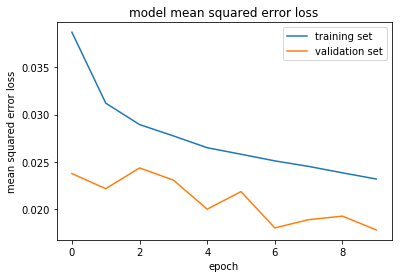

In [1]:
#using Keras 2!
import numpy as np
import os
import csv
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D
import matplotlib.pyplot as plt
import h5py

top_path = 'H:/udacity/p3data/datanew/'

samples = []
with open(top_path + 'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


train_samples, validation_samples = train_test_split(samples, test_size=0.3)


def generator(samples, batch_size):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name_center = batch_sample[0].split('/')[-1]
                name_left = batch_sample[1].split('/')[-1]
                name_right = batch_sample[2].split('/')[-1]                
                center_image = cv2.imread(name_center)
                left_image = cv2.imread(name_left)
                right_image = cv2.imread(name_right)
                
                
                center_angle = float(batch_sample[3])
                # create adjusted steering measurements for the side camera images
                correction = 0.1 # this is a parameter to tune
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                        
                #flip all images and angles
                center_image_f = np.fliplr(center_image)
                center_angle_f = -center_angle
                left_image_f = np.fliplr(left_image)
                left_angle_f = -left_angle
                right_image_f = np.fliplr(right_image)
                right_angle_f = -right_angle
                
                # add images and angles to data set
                images.extend([center_image, left_image, right_image, center_image_f, left_image_f, right_image_f])
                angles.extend([center_angle, left_angle, right_angle, center_angle_f, left_angle_f, right_angle_f])
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
bs = 32
train_generator = generator(train_samples, batch_size=bs)
validation_generator = generator(validation_samples, batch_size=bs)

ch, row, col = 3, 80, 320  # Trimmed image format

#Nvidia architecture plus some preprocessing
model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, ch) ))
model.add(Dropout(0.2))
model.add(Cropping2D(cropping=((60,20), (0,0))))
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(64, (3, 3), strides=(2, 2), activation="relu"))
model.add(Conv2D(64, (3, 3), strides=(2, 2), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, 
            steps_per_epoch= len(train_samples)/bs, validation_data=validation_generator, 
            validation_steps=len(validation_samples)/bs, epochs=10)


model.save('modelb32a.h5')
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
#0.0178